## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.9, 0.4]
redice_lr_patient = [5, 10]

In [12]:
import itertools
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))

Numbers of exp: 0, reduce_factor: 0.90, reduce_patient: 5
Numbers of exp: 1, reduce_factor: 0.90, reduce_patient: 10
Numbers of exp: 2, reduce_factor: 0.40, reduce_patient: 5
Numbers of exp: 3, reduce_factor: 0.40, reduce_patient: 10
Numbers of exp: 4, reduce_factor: 0.90, reduce_patient: 5
Numbers of exp: 5, reduce_factor: 0.90, reduce_patient: 10
Numbers of exp: 6, reduce_factor: 0.40, reduce_patient: 5
Numbers of exp: 7, reduce_factor: 0.40, reduce_patient: 10
Numbers of exp: 8, reduce_factor: 0.90, reduce_patient: 5
Numbers of exp: 9, reduce_factor: 0.90, reduce_patient: 10
Numbers of exp: 10, reduce_factor: 0.40, reduce_patient: 5
Numbers of exp: 11, reduce_factor: 0.40, reduce_patient: 10


In [10]:
import itertools
from keras.callbacks import ReduceLROnPlateau

results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """

    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.90, reduce_patient: 5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.2958 - accuracy: 0.5505 - val_loss: 1.4979 - val_accuracy: 0.4752
Epoch 12/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.2706 - accuracy: 0.5593 - val_loss: 1.4868 - val_accuracy: 0.4748
Epoch 13/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.2457 - accuracy: 0.5699 - val_loss: 1.4835 - val_accuracy: 0.4750
Epoch 14/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.2231 - accuracy: 0.5780 - val_loss: 1.4665 - val_accuracy: 0.4847
Epoch 15/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.1995 - accuracy: 0.5875 - val_loss: 1.4671 - val_accuracy: 0.4844
Epoch 16/25
50000/50000 [==============================] - 5s 110us/step - loss: 1.1773 - accuracy: 0.5950 - val_loss: 1.4634 - val_accuracy: 0.4840
Epoch 17/25
50000/50000 [==============================] - 5s 104us/step - loss: 1.1562 - accuracy: 0.6029 - v

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 102us/step - loss: 2.2488 - accuracy: 0.2592 - val_loss: 2.2124 - val_accuracy: 0.1400
Epoch 2/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.7689 - accuracy: 0.3835 - val_loss: 2.0305 - val_accuracy: 0.2730
Epoch 3/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.6453 - accuracy: 0.4226 - val_loss: 1.8566 - val_accuracy: 0.3471
Epoch 4/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.5694 - accuracy: 0.4496 - val_loss: 1.7334 - val_accuracy: 0.3970
Epoch 5/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.5149 - accuracy: 0.4698 - val_loss: 1.6672 - val_accuracy: 0.4134
Epoch 6/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.4678 - accuracy: 0.4873 - val_loss: 1.6092 - val_accuracy: 0.4365
Epoch 7/25
50000/50000 [==============================] - 5s 100us

50000/50000 [==============================] - 5s 99us/step - loss: 0.6419 - accuracy: 0.7811 - val_loss: 1.8669 - val_accuracy: 0.4365
Epoch 20/25
50000/50000 [==============================] - 5s 99us/step - loss: 0.6060 - accuracy: 0.7931 - val_loss: 2.1585 - val_accuracy: 0.4233
Epoch 21/25
50000/50000 [==============================] - 5s 102us/step - loss: 0.5740 - accuracy: 0.8051 - val_loss: 1.9991 - val_accuracy: 0.4275

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.
Epoch 22/25
50000/50000 [==============================] - 5s 102us/step - loss: 0.5305 - accuracy: 0.8202 - val_loss: 1.8708 - val_accuracy: 0.4659
Epoch 23/25
50000/50000 [==============================] - 5s 99us/step - loss: 0.4918 - accuracy: 0.8372 - val_loss: 1.9038 - val_accuracy: 0.4653
Epoch 24/25
50000/50000 [==============================] - 5s 98us/step - loss: 0.4582 - accuracy: 0.8488 - val_loss: 2.0117 - val_accuracy: 0.4726
Epoch 25/25
50000/50000 [================

50000/50000 [==============================] - 5s 102us/step - loss: 1.5480 - accuracy: 0.4499 - val_loss: 1.8735 - val_accuracy: 0.3441
Epoch 3/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.4558 - accuracy: 0.4826 - val_loss: 1.6398 - val_accuracy: 0.4195
Epoch 4/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.3951 - accuracy: 0.5051 - val_loss: 1.6722 - val_accuracy: 0.4047
Epoch 5/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.3391 - accuracy: 0.5257 - val_loss: 1.5117 - val_accuracy: 0.4559
Epoch 6/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.2940 - accuracy: 0.5422 - val_loss: 1.4663 - val_accuracy: 0.4758
Epoch 7/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.2489 - accuracy: 0.5575 - val_loss: 1.6475 - val_accuracy: 0.4101
Epoch 8/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.2104 - accuracy: 0.5712 - val_loss: 1.571

Epoch 21/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.7190 - accuracy: 0.7676 - val_loss: 1.4446 - val_accuracy: 0.5082

Epoch 00021: ReduceLROnPlateau reducing learning rate to 4.199040122330189e-05.
Epoch 22/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.6612 - accuracy: 0.7967 - val_loss: 1.4125 - val_accuracy: 0.5212
Epoch 23/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.6399 - accuracy: 0.8061 - val_loss: 1.4373 - val_accuracy: 0.5162
Epoch 24/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.6273 - accuracy: 0.8134 - val_loss: 1.4142 - val_accuracy: 0.5239
Epoch 25/25
50000/50000 [==============================] - 5s 102us/step - loss: 0.6145 - accuracy: 0.8179 - val_loss: 1.4231 - val_accuracy: 0.5229
Numbers of exp: 8, reduce_factor: 0.90, reduce_patient: 5
Model: "model_10"
_________________________________________________________________
Layer (type)                 Out

50000/50000 [==============================] - 5s 103us/step - loss: 1.4167 - accuracy: 0.5015 - val_loss: 1.9656 - val_accuracy: 0.3190
Epoch 4/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.3454 - accuracy: 0.5254 - val_loss: 2.0686 - val_accuracy: 0.2898
Epoch 5/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.2862 - accuracy: 0.5457 - val_loss: 1.7946 - val_accuracy: 0.3583
Epoch 6/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.2317 - accuracy: 0.5674 - val_loss: 1.8278 - val_accuracy: 0.3743
Epoch 7/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.1826 - accuracy: 0.5836 - val_loss: 2.0414 - val_accuracy: 0.3396
Epoch 8/25
50000/50000 [==============================] - 5s 102us/step - loss: 1.1431 - accuracy: 0.5969 - val_loss: 1.7108 - val_accuracy: 0.4019
Epoch 9/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.1010 - accuracy: 0.6128 - val_loss: 1.953

Epoch 22/25
50000/50000 [==============================] - 5s 105us/step - loss: 0.5907 - accuracy: 0.8082 - val_loss: 1.5768 - val_accuracy: 0.5029
Epoch 23/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.5656 - accuracy: 0.8197 - val_loss: 1.5827 - val_accuracy: 0.5066
Epoch 24/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.5419 - accuracy: 0.8283 - val_loss: 1.6362 - val_accuracy: 0.4934
Epoch 25/25
50000/50000 [==============================] - 5s 103us/step - loss: 0.5204 - accuracy: 0.8364 - val_loss: 1.6710 - val_accuracy: 0.5015
Numbers of exp: 11, reduce_factor: 0.40, reduce_patient: 10
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376

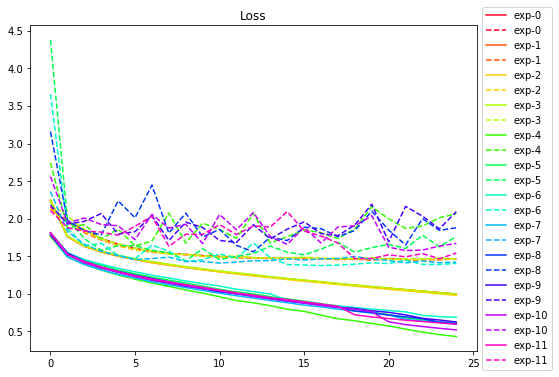

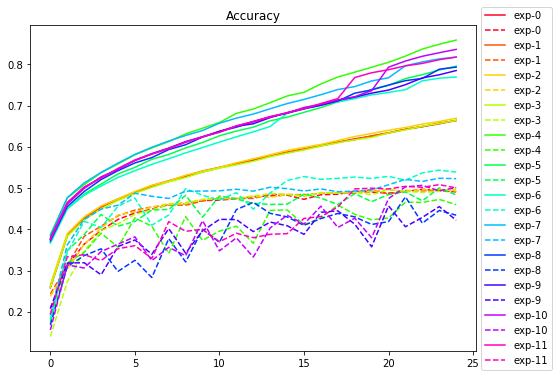

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()